<a href="https://colab.research.google.com/github/alonsomoros/colab/blob/main/Practica_2_1_MNIST_DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
!pip install tensorflow==2.13
!pip install keras==2.13.1

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import random

from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Conv2D, Dense, Activation, Flatten, Reshape, Dropout, UpSampling2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.optimizers import Adam

# Dataset Load

We download MNIST dataset, consisting of 60.000 images of 28x28 pixels resolution. Each image defines a handwritten number in greyscale.

(60000, 28, 28)


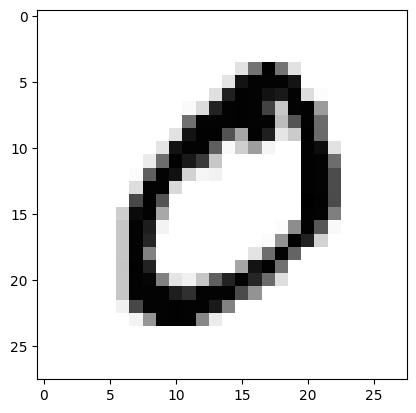

In [7]:
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()
plt.imshow(X_train[1], cmap = 'Greys')
print(X_train.shape)

## Preprocessing data

The pixels in the source image are within the range [0, 256] we will normalize this range to [-1, 1] in order to treat this information with neural networks.

In [8]:
X_train = X_train.astype('float32')/127.5 -1

X_train = np.expand_dims(X_train, axis=3)

# Generator definition

## Responda a las siguientes cuestiones:

* Describa el diseño de las red neuronal Generativa, justificando los hiperparámetros utilizados en la medida de lo posible.

La red generativa toma un vector de entrada aleatorio, llamado vector latente zz de dimensión 100, y lo transforma en una imagen sintética de 28x28 píxeles (en escala de grises) para aproximarse al conjunto de datos de MNIST. Utilizamos una arquitectura que incluye capas de upscaling (UpSampling2D) y convoluciones (Conv2D) para ir aumentando la resolución de la imagen generada. La salida final de la red generativa es una imagen en escala de grises de tamaño 28x28x1, con valores normalizados entre -1 y 1, gracias a la activación tanh en la capa de salida.

* Existen una serie de capas que pueden ser beneficiosas para el entrenamiento de redes GAN, algunas de ellas son las capas de Dropout o BatchNormalization. En caso de utilizar dichas capas justifique su uso. Se **valorará positivamente** responder a este apartado.

La capa BatchNormalization normaliza las activaciones de la red en cada mini-lote, manteniendo la media cercana a cero y la varianza a uno por eso colocamos la capa de BatchNormalization después de cada capa convolucional o capa densa, permitiendo que cada capa trabaje con distribuciones de activación normalizadas, mejorando la estabilidad del entrenamiento.
Por otra parte, la capa Dropout es una técnica de regularización que "apaga" de manera aleatoria un porcentaje de neuronas durante el entrenamiento. Es el dibujo en la teoría con ciertas neuronas como "desactivadas" aleatoriamente.

In [12]:
def create_generator():
    input = Input(shape=(100))

   # Rellene con la red neuronal convolucional deseada

   # Primera capa totalmente conectada
    x = Dense(7 * 7 * 128, activation="relu")(input)
    x = Reshape((7, 7, 128))(x)

    # Capa de convolución transpuesta para aumentar la resolución
    x = UpSampling2D()(x)
    x = Conv2D(128, kernel_size=3, padding="same")(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = LeakyReLU(alpha=0.2)(x)

    # Otra capa de convolución transpuesta
    x = UpSampling2D()(x)
    x = Conv2D(64, kernel_size=3, padding="same")(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = LeakyReLU(alpha=0.2)(x)

    # Capa de salida
    output = Conv2D(1, kernel_size=3, padding="same", activation="tanh")(x)

    generator = Model(input, output)

    return generator

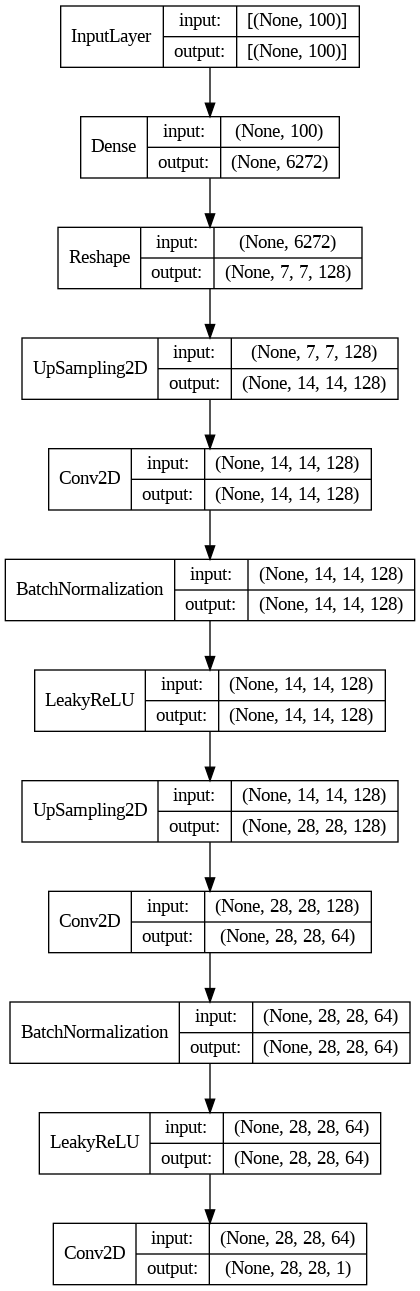

In [13]:
generator = create_generator()
plot_model(generator, show_shapes=True, show_layer_names=False)

# Discriminator definition

## Responda a las siguientes cuestiones:

* Describa el diseño de las red neuronal Discriminadora, justificando los hiperparámetros utilizados en la medida de lo posible.

La red discriminadora toma una imagen de entrada de 28x28 píxeles en escala de grises (dimensión 28x28x1) y determina si esta es real o generada. La arquitectura de la red discriminadora se basa en capas convolucionales para extraer características de la imagen, reduciendo progresivamente la resolución mientras aumenta la cantidad de filtros, permitiendo captar patrones y texturas que diferencien imágenes reales de falsas.

* Existen una serie de capas que pueden ser beneficiosas para el entrenamiento de redes GAN, algunas de ellas son las capas de Dropout o BatchNormalization. En caso de utilizar dichas capas justifique su uso. Se **valorará positivamente** responder a este apartado.

Lo mismo que en el apartado anterior.

In [ ]:
def create_discriminator():
    input = Input(shape=(28, 28, 1))

    # Rellene con la red neuronal convolucional deseada

    x = Conv2D(32, kernel_size=3, strides=2, padding="same")(input)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.25)(x)

    x = Conv2D(64, kernel_size=3, strides=2, padding="same")(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.25)(x)

    x = Conv2D(128, kernel_size=3, strides=2, padding="same")(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.25)(x)

    x = Flatten()(x)
    output = Dense(1, activation="sigmoid")(x)

    discriminator = Model(input, output)

    return discriminator

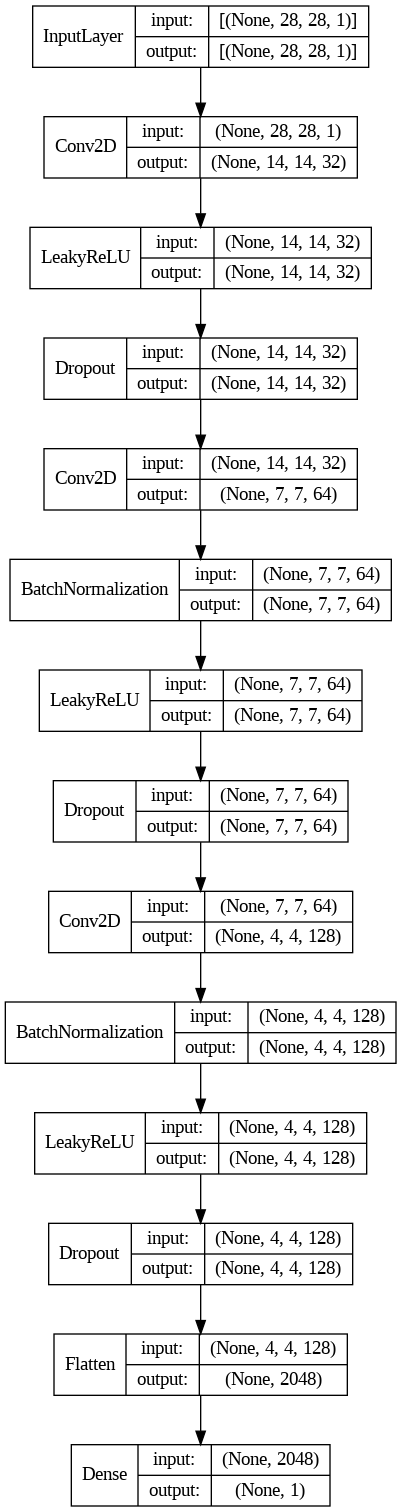

In [15]:
discriminator = create_discriminator()
plot_model(discriminator, show_shapes=True, show_layer_names=False)

# GAN model definition

In [16]:
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])
discriminator.trainable = False

z = Input(shape=(100,))
img = generator(z)
validity = discriminator(img)

combined = Model(z, validity)
combined.compile(loss='binary_crossentropy', optimizer=Adam())

# Training

In [17]:
def train(X_train, generator, discriminator, combined, epochs, batch_size=32, sample_interval=100):
    # Adversarial ground truths (-1 fake and 1 real)
    valid = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    history = {
        'd_loss' : [],
        'd_acc' : [],
        'g_loss' : []
    }

    for epoch in range(epochs):
        print("----EPOCH " + str(epoch) + '-----')
        for batch in range(int(len(X_train)/batch_size)):
            #  Train the Discriminator
            noise = np.random.normal(0, 1, (batch_size, 100))
            gen_imgs = generator.predict(noise, verbose=0)
            imgs = X_train[batch*batch_size : (batch+1)*batch_size]

            d_loss_real = discriminator.train_on_batch(imgs, valid)
            d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # Train the Generator
            noise = np.random.normal(0, 1, (batch_size, 100))
            g_loss = combined.train_on_batch(noise, valid)

            # Save losses
            history['d_loss'].append(d_loss[0])
            history['d_acc'].append(d_loss[1])
            history['g_loss'].append(g_loss)

            # Plot the progress
            if batch % 50 == 0:
                print ("%d [D loss: %.4f,\t acc.: %.2f%%]\t[G loss: %.4f]" % (batch, d_loss[0], 100*d_loss[1], g_loss))

            if batch % 500 == 0:
                sample_images(epoch, batch, gen_imgs, imgs)

        plot_losses(history)

## Plotting functions

In [18]:
def sample_images(epoch, batch, gen_imgs, imgs):
    plt.rcParams['figure.figsize'] = [15, 5]
    fig, axs = plt.subplots(2, 5)
    fig.suptitle('Epoch: ' + str(epoch) + ', Batch: ' + str(batch), fontsize=16)
    for i in range(5):
        axs[0,i].imshow(gen_imgs[i,:,:,0], cmap='Greys')
        axs[0,i].axis('off')

    for i in range(5):
        axs[1,i].imshow(imgs[i,:,:,0], cmap='Greys')
        axs[1,i].axis('off')
    plt.show()
    plt.close()

In [19]:
def plot_losses(history):
    plt.rcParams['figure.figsize'] = [20, 5]
    f, (ax1, ax2) = plt.subplots(1, 2, sharex=True)

    ax1.set_title('Losses')
    ax1.set_xlabel('epoch')
    ax1.legend(loc="upper right")
    ax1.grid()

    ax1.plot(history['d_loss'], label='D loss')
    ax1.plot(history['g_loss'], label='G loss')
    ax1.legend()

    ax2.set_title('D accuracy')
    ax2.set_xlabel('epoch')
    ax2.legend(loc="upper right")
    ax2.grid()

    ax2.plot(history['d_acc'], label='Accuracy')
    ax2.legend()

    plt.show()

## Responda a las siguientes cuestiones:

* Analice los resultados del entrenamiento realizado, identifique posibles problemas que hayan podido surgir en sus redes. En caso de que sea necesario haga más pruebas en otra celda, justificando la evolución y cambios de una a otra.

La falta de nitidez en los dígitos generados indica que el generador puede estar teniendo dificultades para aprender correctamente las características de los datos de entrada.

Un problema común es que el discriminador puede volverse demasiado bueno al principio, haciendo que el generador tenga dificultades para mejorar. Esto parece ser el caso aquí, ya que el generador aún no logra producir dígitos claros después de varios batches.

Una solución posible podría ser agregar capas Dropout o epochs para el aprendizaje. O si se ve que el discriminador sigue dominando, rebajar su nivel para que vayan a la par.

No se ve en su plenitud pero el generador tiene problemas para generar los números debido a que el discriminador aprende más rápido, pero se ve que poco a poco se van reconociendo rasgos de números, dando a entender que el generador también va aprendiendo.

----EPOCH 0-----
0 [D loss: 1.1360,	 acc.: 32.81%]	[G loss: 0.6451]


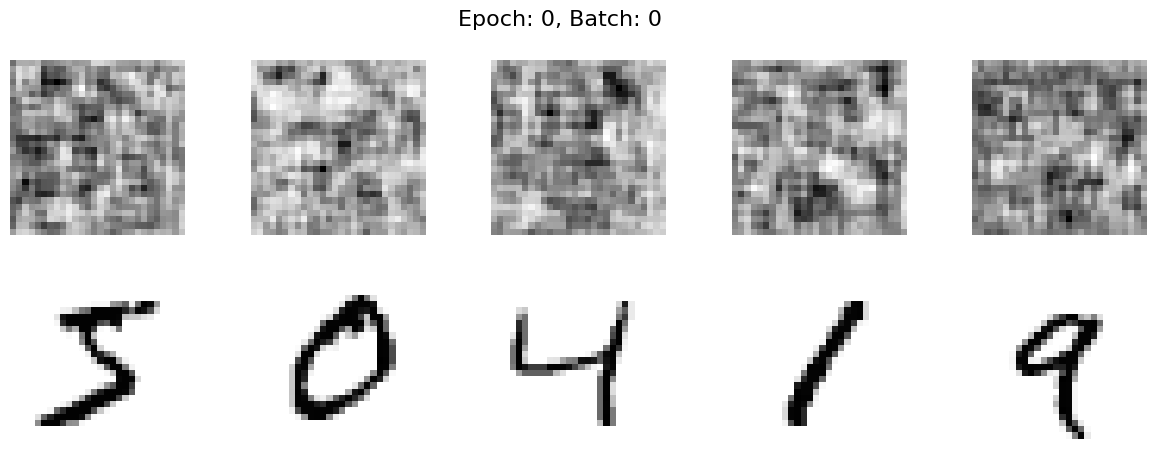

50 [D loss: 0.4001,	 acc.: 85.94%]	[G loss: 0.9233]
100 [D loss: 0.0693,	 acc.: 98.44%]	[G loss: 1.8739]
150 [D loss: 0.0890,	 acc.: 96.88%]	[G loss: 1.3829]
200 [D loss: 0.7701,	 acc.: 64.06%]	[G loss: 1.0033]
250 [D loss: 0.5397,	 acc.: 76.56%]	[G loss: 1.5564]
300 [D loss: 0.1455,	 acc.: 93.75%]	[G loss: 1.1916]
350 [D loss: 0.1508,	 acc.: 98.44%]	[G loss: 1.8331]
400 [D loss: 0.1125,	 acc.: 98.44%]	[G loss: 1.4455]
450 [D loss: 0.0534,	 acc.: 98.44%]	[G loss: 0.6833]
500 [D loss: 0.0105,	 acc.: 100.00%]	[G loss: 0.5324]


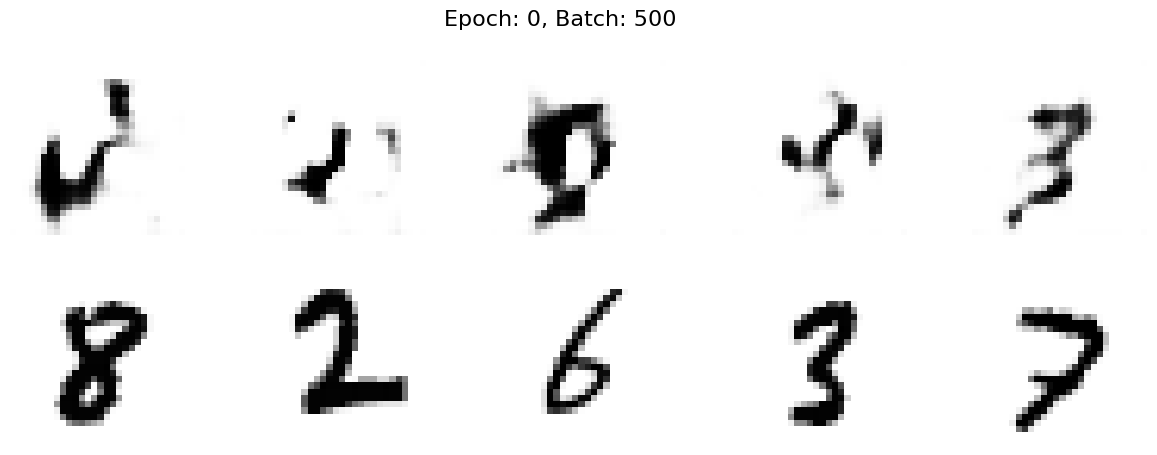

550 [D loss: 0.0300,	 acc.: 100.00%]	[G loss: 0.8317]
600 [D loss: 0.0198,	 acc.: 98.44%]	[G loss: 0.5658]
650 [D loss: 0.0173,	 acc.: 100.00%]	[G loss: 1.0040]
700 [D loss: 0.3205,	 acc.: 82.81%]	[G loss: 0.4537]
750 [D loss: 0.0014,	 acc.: 100.00%]	[G loss: 1.5772]
800 [D loss: 0.0003,	 acc.: 100.00%]	[G loss: 0.7479]
850 [D loss: 0.0026,	 acc.: 100.00%]	[G loss: 2.6366]
900 [D loss: 0.0001,	 acc.: 100.00%]	[G loss: 5.4728]
950 [D loss: 0.0000,	 acc.: 100.00%]	[G loss: 1.8332]
1000 [D loss: 0.0000,	 acc.: 100.00%]	[G loss: 0.5292]


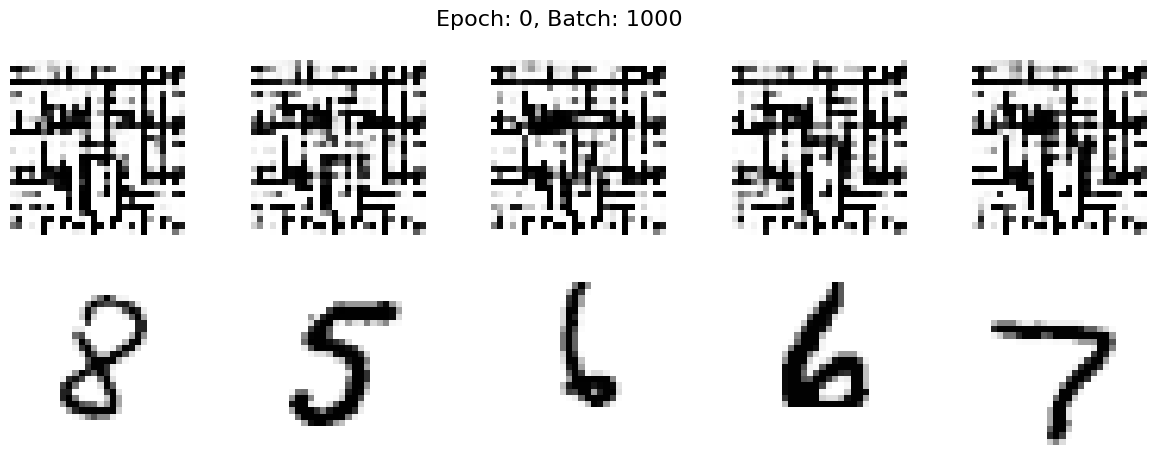

1050 [D loss: 0.0000,	 acc.: 100.00%]	[G loss: 0.0647]
1100 [D loss: 0.0001,	 acc.: 100.00%]	[G loss: 0.1053]
1150 [D loss: 0.0001,	 acc.: 100.00%]	[G loss: 0.0613]
1200 [D loss: 0.0001,	 acc.: 100.00%]	[G loss: 0.0845]
1250 [D loss: 0.0001,	 acc.: 100.00%]	[G loss: 0.0608]
1300 [D loss: 0.0000,	 acc.: 100.00%]	[G loss: 0.1141]
1350 [D loss: 0.0001,	 acc.: 100.00%]	[G loss: 0.0376]
1400 [D loss: 0.0001,	 acc.: 100.00%]	[G loss: 0.0431]
1450 [D loss: 0.0000,	 acc.: 100.00%]	[G loss: 0.1128]
1500 [D loss: 0.0004,	 acc.: 100.00%]	[G loss: 0.1154]


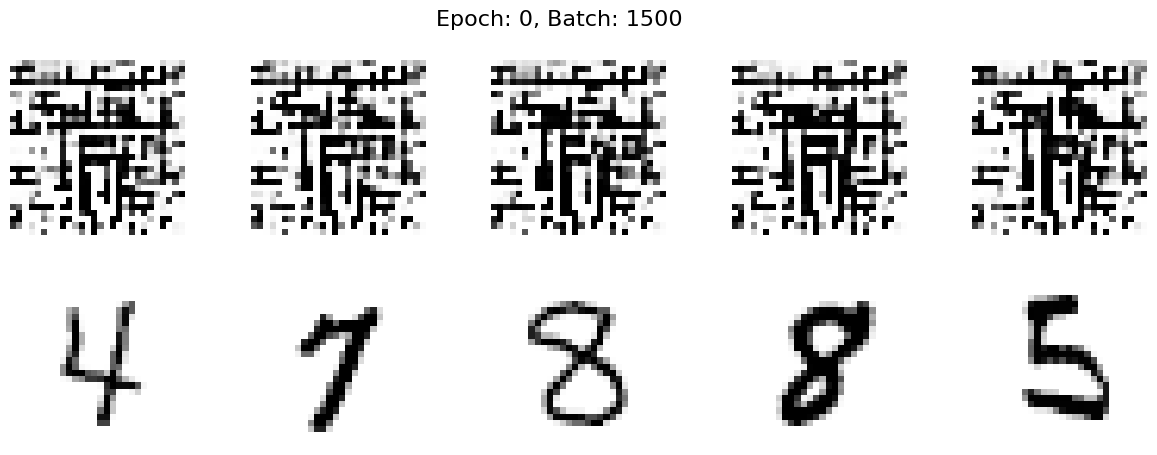

1550 [D loss: 0.0529,	 acc.: 96.88%]	[G loss: 13.7188]
1600 [D loss: 0.6763,	 acc.: 60.94%]	[G loss: 0.2545]
1650 [D loss: 0.0015,	 acc.: 100.00%]	[G loss: 0.4650]


In [ ]:
train(X_train, generator, discriminator, combined, epochs=10, batch_size=32, sample_interval=100)

---

Creado por **Guillermo Iglesias** (guillermo.iglesias@upm.es)

<img src="https://licensebuttons.net/l/by-nc-sa/3.0/88x31.png">